In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import bisect

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
indexData = pd.read_csv('../data/indexData_webbase_uint16.txt', sep='\t', header=None)

In [3]:
header = ['Term', 'Li_Len', '1s_Qnt', '1rl_Avg', 'Liwo1_Len', 'C_Li_Len', 'C_Liwo1_Len', 'Bitmap_Bytes',
          'Bitmap_BytesOnDisk', 'EWAH_bitmap_Bytes', 'EWAH_bitmap_BytesOnDisk', 'Bitmap_1s']
indexData.columns = header

In [4]:
#indexData['Bitmap_Bytes'] = indexData.Li_Len / 8 + 1
indexData['Li_Bytes'] = indexData.Li_Len * 4
indexData['Liwo1_Bytes'] = indexData.Liwo1_Len * 4
indexData['C_Li_Bytes'] = indexData.C_Li_Len * 4
indexData['C_Liwo1_Bytes'] = indexData.C_Liwo1_Len * 4
indexData['Ones_Ratio'] = indexData['1s_Qnt'] / indexData.Li_Len

# SS_Ratio (Space Saving): 1 - (CompressedSize / UncompressedSize) #
indexData['SS_Ratio_Li'] = 1 - (indexData.C_Li_Bytes / indexData.Li_Bytes)
indexData['SS_Ratio_Liwo1'] = 1 - (indexData.C_Liwo1_Bytes / indexData.Liwo1_Bytes)

indexData['SS_Ratio_Hybrid_Un'] = 1 - (indexData.Liwo1_Bytes + indexData.Bitmap_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co'] = 1 - (indexData.C_Liwo1_Bytes + indexData.EWAH_bitmap_Bytes) / indexData.Li_Bytes

indexData['SS_Ratio_Hybrid_Un_woBitmap'] = 1 - (indexData.Liwo1_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co_woBitmap'] = 1 - (indexData.C_Liwo1_Bytes) / indexData.Li_Bytes

indexData['C_Li_wo1_EWAH_bitmap_Bytes'] = indexData.C_Liwo1_Bytes + indexData.EWAH_bitmap_Bytes


In [5]:
indexData[indexData.columns[1:]]
#indexData[['SS_Ratio_Li', 'SS_Ratio_Liwo1', 'SS_Ratio_Hybrid_Un', 'SS_Ratio_Hybrid_Co']]

,Li_Len,1s_Qnt,1rl_Avg,Liwo1_Len,C_Li_Len,C_Liwo1_Len,Bitmap_Bytes,Bitmap_BytesOnDisk,EWAH_bitmap_Bytes,EWAH_bitmap_BytesOnDisk,...,C_Li_Bytes,C_Liwo1_Bytes,Ones_Ratio,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co,SS_Ratio_Hybrid_Un_woBitmap,SS_Ratio_Hybrid_Co_woBitmap,C_Li_wo1_EWAH_bitmap_Bytes
0,2490722,2024405,10.698,466317,202008,77788,253052,253060,996,1012,...,808032,311152,0.813,0.919,0.833,0.787,0.969,0.813,0.969,312148
1,915500,563926,5.205,351574,116035,66355,70492,70500,280,296,...,464140,265420,0.616,0.873,0.811,0.597,0.927,0.616,0.928,265700
2,1138505,657931,4.614,480574,140061,85173,82242,82250,326,342,...,560244,340692,0.578,0.877,0.823,0.560,0.925,0.578,0.925,341018
3,34542,24129,11.197,10413,5220,3463,3018,3026,14,30,...,20880,13852,0.699,0.849,0.667,0.677,0.900,0.699,0.900,13866
4,1492,839,2.975,653,252,137,106,114,4,20,...,1008,548,0.562,0.831,0.790,0.545,0.908,0.562,0.908,552
5,29,1,1.000,28,15,15,2,10,4,20,...,60,60,0.034,0.483,0.464,0.017,0.448,0.034,0.483,64
6,4,2,2.000,2,3,3,2,10,4,20,...,12,12,0.500,0.250,-0.500,0.375,0.000,0.500,0.250,16
7,4,2,2.000,2,3,3,2,10,4,20,...,12,12,0.500,0.250,-0.500,0.375,0.000,0.500,0.250,16
8,225,47,1.237,178,79,67,6,14,4,20,...,316,268,0.209,0.649,0.624,0.202,0.698,0.209,0.702,272
9,4,2,2.000,2,3,3,2,10,4,20,...,12,12,0.500,0.250,-0.500,0.375,0.000,0.500,0.250,16


In [6]:
# Size of vocabulary: 14813510 (terms) #
# 2134281 / 14813510 = 0.144076657 #
indexData[indexData.columns[9:]].describe()

,EWAH_bitmap_Bytes,EWAH_bitmap_BytesOnDisk,Bitmap_1s,Li_Bytes,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,Ones_Ratio,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co,SS_Ratio_Hybrid_Un_woBitmap,SS_Ratio_Hybrid_Co_woBitmap,C_Li_wo1_EWAH_bitmap_Bytes
count,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000
mean,4.299,20.299,741.503,5324.862,2358.851,909.008,651.827,0.284,0.326,0.120,0.216,0.297,0.284,0.428,656.126
std,12.078,12.078,24693.355,130893.301,39312.353,13268.505,7625.407,0.219,0.332,0.522,0.197,0.394,0.219,0.256,7633.479
min,2.000,18.000,1.000,8.000,4.000,8.000,8.000,0.002,-0.500,-1.000,0.001,-0.500,0.002,0.000,10.000
25%,4.000,20.000,1.000,20.000,12.000,16.000,12.000,0.106,0.200,0.000,0.072,0.000,0.106,0.250,16.000
50%,4.000,20.000,2.000,64.000,44.000,36.000,28.000,0.215,0.420,0.333,0.167,0.400,0.215,0.465,32.000
75%,4.000,20.000,10.000,232.000,180.000,100.000,88.000,0.475,0.551,0.500,0.250,0.581,0.475,0.609,92.000
max,3098.000,3114.000,6313430.000,26436656.000,3736772.000,1372912.000,517940.000,1.000,0.962,0.916,0.968,1.000,1.000,1.000,518592.000


In [7]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
count_won_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)
count_lost_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)

#won_SS_SS_Ratio_Hybrid_Co = indexData[indexData['SS_Ratio_Hybrid_Co'] > indexData['SS_Ratio_Hybrid_Co']]['SS_Ratio_Hybrid_Co']
won_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])
lost_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])

# Interval Type [) #
for SS_Ratio_Hybrid_Co in won_SS_Ratio_Hybrid_Co:
    count_won_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
for SS_Ratio_Hybrid_Co in lost_SS_Ratio_Hybrid_Co:
    # First interval includes NEGATIVE values #
    count_lost_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
    
# Slower! #
#for index, row in indexData.iterrows():
#    if (row.SS_Ratio_Hybrid_Co > row.SS_Ratio_Li):
#        count_won_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1
#    else: # row.SS_Ratio_Hybrid_Co <= row.SS_Ratio_Li] #
#        count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Co = (count_won_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100
count_lost_SS_Ratio_Hybrid_Co = (count_lost_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon\t\tLost'
previousBin = 0.0
totalWon = 0.0
totalLost = 0.0
for won, lost, bi in zip(count_won_SS_Ratio_Hybrid_Co, count_lost_SS_Ratio_Hybrid_Co, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, won, lost)
    previousBin = bi
    totalWon += won
    totalLost += lost
print 'Total\t\t%.2f\t\t%.2f' %(totalWon, totalLost)


Bin		Won		Lost
[0.0, 0.1)	0.00		26.44
[0.1, 0.2)	0.00		6.96
[0.2, 0.3)	0.00		6.04
[0.3, 0.4)	0.21		9.26
[0.4, 0.5)	2.59		10.11
[0.5, 0.6)	8.26		7.51
[0.6, 0.7)	9.29		2.21
[0.7, 0.8)	5.34		0.17
[0.8, 0.9)	3.18		0.01
[0.9, 1.0)	2.41		0.00
Total		31.28		68.72


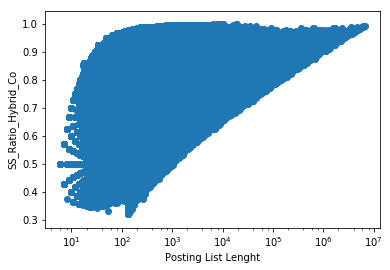

In [8]:
# SS_Ratio_Li / SS_Ratio_Hybrid_Co #

won_SS_Ratio_Hybrid_Co_dataFrame = indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')[['Li_Len','SS_Ratio_Hybrid_Co']]
figure, ax = plt.subplots()
ax.scatter(won_SS_Ratio_Hybrid_Co_dataFrame.Li_Len, won_SS_Ratio_Hybrid_Co_dataFrame.SS_Ratio_Hybrid_Co)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co')
ax.set_xscale('log')
#ax.set_yscale('log')

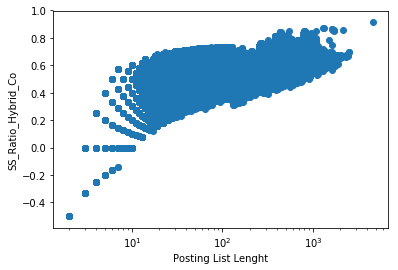

In [9]:
# SS_Ratio_Li / SS_Ratio_Hybrid_Co #

lost_SS_Ratio_Hybrid_Co_dataFrame = indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')[['Li_Len','SS_Ratio_Hybrid_Co']]
figure, ax = plt.subplots()
ax.scatter(lost_SS_Ratio_Hybrid_Co_dataFrame.Li_Len, lost_SS_Ratio_Hybrid_Co_dataFrame.SS_Ratio_Hybrid_Co)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co')
ax.set_xscale('log')
#ax.set_yscale('log')

In [10]:
won_Hybrid_Co = indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')
lost_Hybrid_Co = indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')

print 'Posting List Lenght (Li_Bytes)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t%.2f\t%i\t\t%i' %(won_Hybrid_Co.Li_Bytes.mean(), won_Hybrid_Co.Li_Bytes.std(),
                                    won_Hybrid_Co.Li_Bytes.min(), won_Hybrid_Co.Li_Bytes.max())
print 'Lost\t%.2f\t\t%.2f\t\t%i\t\t%i' %(lost_Hybrid_Co.Li_Bytes.mean(), lost_Hybrid_Co.Li_Bytes.std(),
                                         lost_Hybrid_Co.Li_Bytes.min(), lost_Hybrid_Co.Li_Bytes.max())

print ''
print 'Average 1\'s run Lenght (1rl_Avg)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(won_Hybrid_Co['1rl_Avg'].mean(), won_Hybrid_Co['1rl_Avg'].std(),
                                            won_Hybrid_Co['1rl_Avg'].min(), won_Hybrid_Co['1rl_Avg'].max())
print 'Lost\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(lost_Hybrid_Co['1rl_Avg'].mean(), lost_Hybrid_Co['1rl_Avg'].std(),
                                             lost_Hybrid_Co['1rl_Avg'].min(), lost_Hybrid_Co['1rl_Avg'].max())

print ''
print '1\'s Ratio (Ones_Ratio)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(won_Hybrid_Co['Ones_Ratio'].mean(), won_Hybrid_Co['Ones_Ratio'].std(),
                                            won_Hybrid_Co['Ones_Ratio'].min(), won_Hybrid_Co['Ones_Ratio'].max())
print 'Lost\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(lost_Hybrid_Co['Ones_Ratio'].mean(), lost_Hybrid_Co['Ones_Ratio'].std(),
                                             lost_Hybrid_Co['Ones_Ratio'].min(), lost_Hybrid_Co['Ones_Ratio'].max())

Posting List Lenght (Li_Bytes)
	Average		Std		Min		Max
Won	16858.36	233609.07	24		26436656
Lost	74.15		197.08		8		18452

Average 1's run Lenght (1rl_Avg)
	Average		Std		Min		Max
Won	7.41		35.11		1.0000		9462.5000
Lost	1.28		0.66		1.0000		59.0000

1's Ratio (Ones_Ratio)
	Average		Std		Min		Max
Won	0.35		0.27		0.0030		0.9997
Lost	0.25		0.19		0.0016		0.8571


In [8]:
count_won_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)
#count_lost_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)

won_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un > 0')['SS_Ratio_Hybrid_Un'])
#lost_SS_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un <= 0')['SS_Ratio_Hybrid_Un'])

# Interval Type [) #
for SS_Ratio_Hybrid_Un in won_SS_Ratio_Hybrid_Un:
    count_won_SS_Ratio_Hybrid_Un[bisect.bisect_right(bins, SS_Ratio_Hybrid_Un)] += 1
#for SS_Ratio_Hybrid_Co in lost_SS_SS_Ratio_Hybrid_Un:
#    count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Un = (count_won_SS_Ratio_Hybrid_Un / indexData.shape[0]) * 100
#count_lost_SS_SS_Ratio_Hybrid_Co = (count_lost_SS_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon'
previousBin = 0.0
totalWon = 0.0
for won, bi in zip(count_won_SS_Ratio_Hybrid_Un, bins):
    print '[%.1f, %.1f)\t%.2f' %(previousBin, bi, won)
    previousBin = bi
    totalWon += won
print 'Total\t\t%.2f' %(totalWon)



Bin		Won
[0.0, 0.1)	35.73
[0.1, 0.2)	23.56
[0.2, 0.3)	18.49
[0.3, 0.4)	7.91
[0.4, 0.5)	3.38
[0.5, 0.6)	4.31
[0.6, 0.7)	2.12
[0.7, 0.8)	1.87
[0.8, 0.9)	1.52
[0.9, 1.0)	1.10
Total		100.00


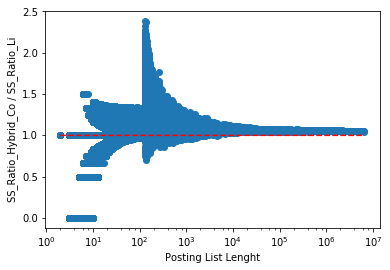

In [10]:
# SS_Ratio_Hybrid_Co / SS_Ratio_Li #

SS_Ratio_Hybrid_Co_over_SS_Ratio_Li = indexData.SS_Ratio_Hybrid_Co / indexData.SS_Ratio_Li

start = indexData.Li_Len.min()
stop = indexData.Li_Len.max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData.Li_Len, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')
#ax.set_yscale('log')

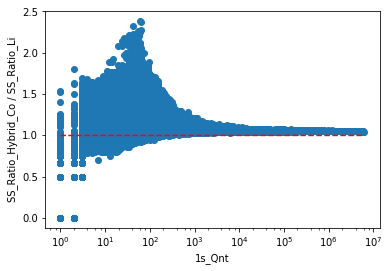

In [11]:
start = indexData['1s_Qnt'].min()
stop = indexData['1s_Qnt'].max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData['1s_Qnt'], SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.set_xlabel('1s_Qnt')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')

(0.0, 1.1)

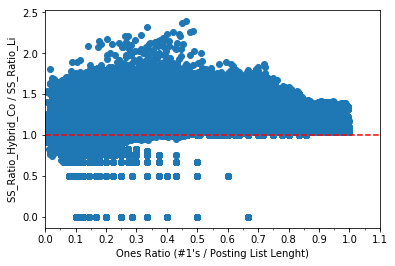

In [12]:
# How many ones do I need to win? #
# X-axis : One's proportion respect to Posting List Length #
# Y-axis : Hybrid Compression Ratio: HybridCompression / PForCompression #

start = 0.0
stop = 1.1

size = indexData.shape[0]

s = np.linspace(start, stop, size, dtype=np.float64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.scatter(indexData.Ones_Ratio, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.plot(s, threshold, color='r', linestyle='--')
# Tickers #
min_x = MultipleLocator(0.05)
max_x = MultipleLocator(0.1)
ax.xaxis.set_major_locator(max_x)
ax.xaxis.set_minor_locator(min_x)
ax.set_xlabel('Ones Ratio (#1\'s / Posting List Lenght)')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xlim([0.0, 1.1])

In [9]:
# C_Li_Len vs C_Liwo1_Len 
C_Li_Len_vs_C_Liwo1_Len_count_more = 0
C_Li_Len_vs_C_Liwo1_Len_count_less_equal = 0
assert (indexData.C_Li_Len.shape[0] == indexData.C_Liwo1_Len.shape[0]), "Error de tamaño"
for C_Li_Len, C_Liwo1_Len in zip(indexData.C_Li_Len.values, indexData.C_Liwo1_Len.values):
    if (C_Li_Len > C_Liwo1_Len):
        C_Li_Len_vs_C_Liwo1_Len_count_more += 1
    else: #(C_Li_Len >= C_Liwo1_Len)
        C_Li_Len_vs_C_Liwo1_Len_count_less_equal += 1
    
print 'C_Li_Len > C_Liwo1_Len: %i out of %i (%.4f)' % (C_Li_Len_vs_C_Liwo1_Len_count_more, indexData.C_Li_Len.shape[0], float(C_Li_Len_vs_C_Liwo1_Len_count_more) / indexData.C_Li_Len.shape[0])
print 'C_Li_Len < C_Liwo1_Len: %i out of %i (%.4f)' % (C_Li_Len_vs_C_Liwo1_Len_count_less_equal, indexData.C_Li_Len.shape[0], float(C_Li_Len_vs_C_Liwo1_Len_count_less_equal) / indexData.C_Li_Len.shape[0])

C_Li_Len_vs_C_Liwo1_Len_more = indexData.query('C_Li_Len > C_Liwo1_Len')['Li_Len']
C_Li_Len_vs_C_Liwo1_Len_less_equal = indexData.query('C_Li_Len <= C_Liwo1_Len')['Li_Len']

C_Li_Len > C_Liwo1_Len: 1445098 out of 2134281 (0.6771)
C_Li_Len < C_Liwo1_Len: 689183 out of 2134281 (0.3229)


In [10]:
logBins = np.logspace(1.0, 7, num=7, dtype=np.uint64)
bin_count_C_Li_Len_vs_C_Liwo1_Len_more = np.zeros(7, dtype=np.uint64)
bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal = np.zeros(7, dtype=np.uint64)
# Interval Type [) #
for Li_Len in C_Li_Len_vs_C_Liwo1_Len_more.values:
    bin_count_C_Li_Len_vs_C_Liwo1_Len_more[bisect.bisect_right(logBins, Li_Len)] += 1

for Li_Len in C_Li_Len_vs_C_Liwo1_Len_less_equal.values:
    bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal[bisect.bisect_right(logBins, Li_Len)] += 1

[      10      100     1000    10000   100000  1000000 10000000]


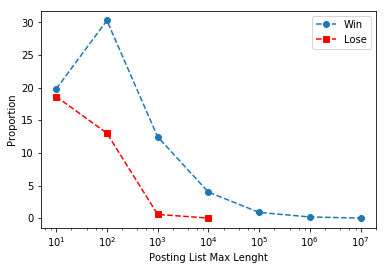

In [11]:
figure, ax = plt.subplots()
y = (bin_count_C_Li_Len_vs_C_Liwo1_Len_more.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100
ax.plot(logBins, y, marker='o', linestyle='--', label='Win')
y = (bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100
ax.plot(logBins[:4], y[:4], color='r', marker='s', linestyle='--', label='Lose')
ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Proportion')
ax.set_xscale('log')
#x.set_yscale('log')
ax.legend()
print logBins


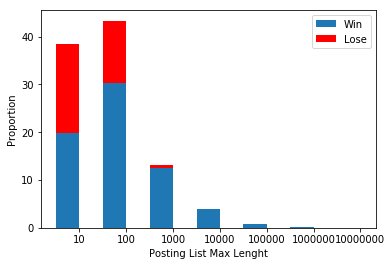

In [15]:
figure, ax = plt.subplots()
x = np.arange(7)

y1 = (bin_count_C_Li_Len_vs_C_Liwo1_Len_more.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100
ax1 = ax.bar(x, y1, 0.50)

y2 = (bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100
ax2 = ax.bar(x, y2, 0.50, bottom=y1, color='r')

plt.xticks(x + 0.5/2., map(lambda x: str(x), logBins))

ax.legend((ax1[0], ax2[0]), ('Win', 'Lose'))
ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Proportion')

[  51.50884495   69.92069772   95.51873173   99.45242746  100.          100.
  100.        ]
[ 48.49115505  30.07930228   4.48126827   0.54757254   0.           0.           0.        ]


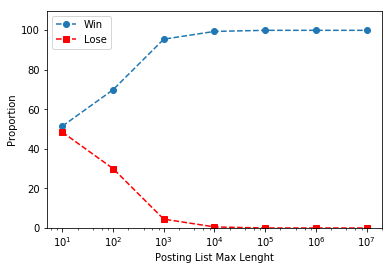

In [16]:
bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_more = np.zeros(7, dtype=np.float64)
bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_less_equal = np.zeros(7, dtype=np.float64)

for i, (more, less_equal) in enumerate(zip(bin_count_C_Li_Len_vs_C_Liwo1_Len_more, bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal)):
    bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_more[i] = (np.float64(more) / (more + less_equal)) * 100
    bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_less_equal[i] = (np.float64(less_equal) / (more + less_equal)) * 100

print bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_more
print bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_less_equal

figure, ax = plt.subplots()
ax.plot(logBins, bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_more, marker='o', linestyle='--', label='Win')
ax.plot(logBins, bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_less_equal, color='r', marker='s', linestyle='--', label='Lose')
ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Proportion')
ax.set_xscale('log')
ax.set_ylim([0, 110])
#x.set_yscale('log')
ax.legend(loc=2)


In [12]:
logBins = np.logspace(1.0, 7, num=7, dtype=np.uint64)
C_Li_wo1_EWAH_bitmap_Bytes_win = indexData.query('C_Li_wo1_EWAH_bitmap_Bytes < C_Li_Bytes')
C_Li_wo1_EWAH_bitmap_Bytes_lose = indexData.query('C_Li_wo1_EWAH_bitmap_Bytes >= C_Li_Bytes')

# Tamaño de la 'lista sin unos comprimida' para el enfoque híbrido
# Bins de acuerdo a Longitud de la Lista
bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win = np.zeros(7, dtype=np.uint64)
bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose = np.zeros(7, dtype=np.uint64)

average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win = np.zeros(7, dtype=np.float64)
average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose = np.zeros(7, dtype=np.float64)

average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win = np.zeros(7, dtype=np.float64)
average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose = np.zeros(7, dtype=np.float64)

# Interval Type [) #
for row in C_Li_wo1_EWAH_bitmap_Bytes_win.values:
    Li_Len = row[1] # Longitud de la Lista (# de entradas)
    SS_Ratio_Hybrid_Co = row[20] # Space Saving Ratio
    Ones_Ratio = row[16] # Proporción de Unos
    index = bisect.bisect_right(logBins, Li_Len)
    bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win[index] += 1 
    average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win[index] += SS_Ratio_Hybrid_Co
    average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win[index] += Ones_Ratio

for row in C_Li_wo1_EWAH_bitmap_Bytes_lose.values:
    Li_Len = row[1]
    #SS_Ratio_Li = row[17]
    Ones_Ratio = row[16]
    SS_Ratio_Hybrid_Co = row[20]
    index = bisect.bisect_right(logBins, Li_Len)
    bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[index] += 1
    average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[index] += SS_Ratio_Hybrid_Co
    average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[index] += Ones_Ratio

print (bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100
print (bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100

[  0.30895651  13.90205882  11.95742266   4.00486159   0.89758565
   0.19505398   0.01771088]
[  3.81439932e+01   2.94412498e+01   1.10575880e+00   2.53481149e-02
   0.00000000e+00   0.00000000e+00   0.00000000e+00]


[   0.80346633   32.07429075   91.53530245   99.37104725  100.          100.
  100.        ]
[ 99.19653367  67.92570925   8.46469755   0.62895275   0.           0.           0.        ]


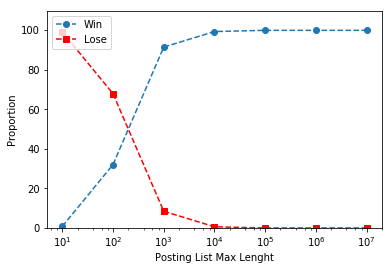

In [13]:
bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_win = np.zeros(7, dtype=np.float64)
bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_lose = np.zeros(7, dtype=np.float64)

for i, (more, less_equal) in enumerate(zip(bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win, bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose)):
    bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_win[i] = (np.float64(more) / (more + less_equal)) * 100
    bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_lose[i] = (np.float64(less_equal) / (more + less_equal)) * 100

print bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_win
print bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_lose

# El eje de las ordenadas representa la proporcion (absoluta) de listas de acuerdo al criterio:
# Si C_Li_wo1_EWAH_bitmap_Bytes < C_Li_Bytes entonces 'win'
# Si C_Li_wo1_EWAH_bitmap_Bytes > C_Li_Bytes entonces 'lose'
figure, ax = plt.subplots()
ax.plot(logBins, bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_win, marker='o', linestyle='--', label='Win')
ax.plot(logBins, bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_lose, color='r', marker='s', linestyle='--', label='Lose')
ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Proportion')
ax.set_xscale('log')
ax.set_ylim([0, 110])
#x.set_yscale('log')
ax.legend(loc=2)

In [19]:
print average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose
print bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose

print average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win
print bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win

[ -84517.90317468  262371.35294103   12772.79411402     340.21559356
       0.               0.               0.        ]
[814100 628359  23600    541      0      0      0]
[   3678.40079365  196213.72278931  160832.02314541   62161.49796269
   15942.9607539     3698.81564425     358.60475914]
[  6594 296709 255205  85475  19157   4163    378]


In [20]:
average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win = average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win / bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win
average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:4] = average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:4] / bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:4]

Posting List Max Lenght		 SS_Ratio_Hybrid_Co_win		 SS_Ratio_Hybrid_Co_lose
10 				 0.56 				 -0.10
100 				 0.66 				 0.42
1000 				 0.63 				 0.54
10000 				 0.73 				 0.63
100000 				 0.83 				 0.00
1000000 				 0.89 				 0.00
10000000 				 0.95 				 0.00


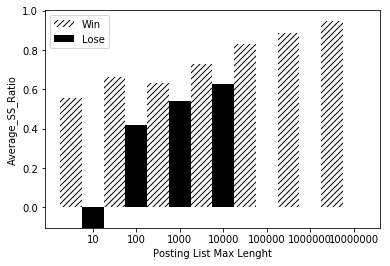

In [48]:
figure, ax = plt.subplots()
x = np.arange(7)

width = 0.5

ax.bar(x, average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win, width, color='w', hatch='////', label='Win')
ax.bar(x + width, average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose, width , color='black', label='Lose')

plt.xticks(x + 0.5, map(lambda x: str(x), logBins))

ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Average_SS_Ratio')
ax.legend(loc=2)

print "Posting List Max Lenght\t\t SS_Ratio_Hybrid_Co_win\t\t SS_Ratio_Hybrid_Co_lose"
for i, (win, lose) in enumerate(zip(average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win, average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose)):
    print "%i \t\t\t\t %.2f \t\t\t\t %.2f" % (logBins[i], win, lose)

In [22]:
average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win = average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win / bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win
average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:4] = average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:4] / bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:4]

Posting List Max Lenght		 Ones_Ratio_Hybrid_Co_Win		 Ones_Ratio_Hybrid_Co_lose
10 				 0.78 				 0.37
100 				 0.42 				 0.12
1000 				 0.25 				 0.05
10000 				 0.33 				 0.05
100000 				 0.47 				 0.00
1000000 				 0.54 				 0.00
10000000 				 0.70 				 0.00


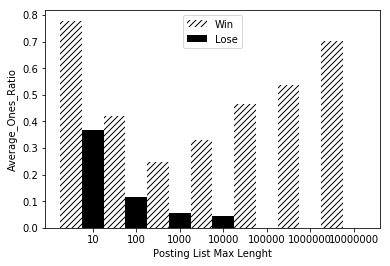

In [47]:
figure, ax = plt.subplots()
x = np.arange(7)

width = 0.5

ax.bar(x, average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win, width, color='w', hatch='////', label='Win')
ax.bar(x + width, average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose, width , color='black', label='Lose')

plt.xticks(x + 0.5, map(lambda x: str(x), logBins))

ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Average_Ones_Ratio')
ax.legend(loc=9)

print "Posting List Max Lenght\t\t Ones_Ratio_Hybrid_Co_Win\t\t Ones_Ratio_Hybrid_Co_lose"
for i, (win, lose) in enumerate(zip(average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win, average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose)):
    print "%i \t\t\t\t %.2f \t\t\t\t %.2f" % (logBins[i], win, lose)

In [14]:
logBins = np.logspace(1.0, 7, num=7, dtype=np.uint64)
bin_absolute_proportion_indexData = np.zeros(7, dtype=np.float64)
average_SS_Ratio_Hybrid_Co_indexData = np.zeros(7, dtype=np.float64)
average_SS_Ratio_Li_indexData = np.zeros(7, dtype=np.float64)

average_Li_Bytes_indexData = np.zeros(7, dtype=np.float64)
average_C_Li_Bytes_indexData = np.zeros(7, dtype=np.float64)
average_C_Li_wo1_EWAH_bitmap_Bytes_indexData = np.zeros(7, dtype=np.float64)

Li_Bytes_indexData = np.zeros(7, dtype=np.uint)
C_Li_Bytes_indexData = np.zeros(7, dtype=np.uint64)
C_Li_wo1_EWAH_bitmap_Bytes_indexData = np.zeros(7, dtype=np.uint64)

# max(uint64) = 8446744073709551615

for row in indexData.values:
    Li_Len = row[1]
    SS_Ratio_Hybrid_Co = row[20]
    SS_Ratio_Li = row[17]
    Li_Bytes = row[12]
    C_Li_Bytes = row[14]
    C_Li_wo1_EWAH_bitmap_Bytes = row[23]
    index = bisect.bisect_right(logBins, Li_Len)
    bin_absolute_proportion_indexData[index] += 1
    average_SS_Ratio_Hybrid_Co_indexData[index] += SS_Ratio_Hybrid_Co
    average_SS_Ratio_Li_indexData[index] += SS_Ratio_Li
    average_Li_Bytes_indexData[index] += Li_Bytes
    average_C_Li_Bytes_indexData[index] += C_Li_Bytes
    average_C_Li_wo1_EWAH_bitmap_Bytes_indexData[index] += C_Li_wo1_EWAH_bitmap_Bytes
    Li_Bytes_indexData[index] += Li_Bytes
    C_Li_Bytes_indexData[index] += C_Li_Bytes
    C_Li_wo1_EWAH_bitmap_Bytes_indexData[index] += C_Li_wo1_EWAH_bitmap_Bytes
    
average_SS_Ratio_Hybrid_Co_indexData = average_SS_Ratio_Hybrid_Co_indexData / bin_absolute_proportion_indexData
average_SS_Ratio_Li_indexData = average_SS_Ratio_Li_indexData / bin_absolute_proportion_indexData
average_Li_Bytes_indexData = average_Li_Bytes_indexData / bin_absolute_proportion_indexData
average_C_Li_Bytes_indexData = average_C_Li_Bytes_indexData / bin_absolute_proportion_indexData
average_C_Li_wo1_EWAH_bitmap_Bytes_indexData = average_C_Li_wo1_EWAH_bitmap_Bytes_indexData / bin_absolute_proportion_indexData

print bin_absolute_proportion_indexData

#print average_SS_Ratio_Hybrid_Co_indexData
#print average_SS_Ratio_Li_indexData
#print average_Li_Bytes_indexData
#print average_C_Li_Bytes_indexData
#print average_C_Li_wo1_EWAH_bitmap_Bytes_indexData
#print Li_Bytes_indexData
#print C_Li_Bytes_indexData
#print C_Li_wo1_EWAH_bitmap_Bytes_indexData

[  8.20694000e+05   9.25068000e+05   2.78805000e+05   8.60160000e+04
   1.91570000e+04   4.16300000e+03   3.78000000e+02]


Posting List Max Lenght		 SS_Ratio_Hybrid_Co		 SS_Ratio_Li
10 				 -0.10 				 0.02
100 				 0.50 				 0.49
1000 				 0.62 				 0.55
10000 				 0.73 				 0.68
100000 				 0.83 				 0.79
1000000 				 0.89 				 0.84
10000000 				 0.95 				 0.90


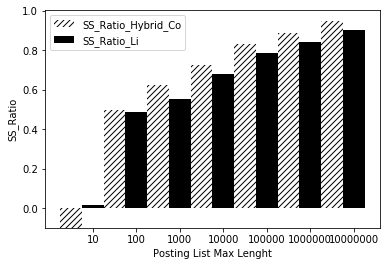

In [15]:
figure, ax = plt.subplots()
x = np.arange(7)

width = 0.5

ax.bar(x, average_SS_Ratio_Hybrid_Co_indexData, width, color='w', hatch='////', label='SS_Ratio_Hybrid_Co')
ax.bar(x + width, average_SS_Ratio_Li_indexData, width , color='black', label='SS_Ratio_Li')

plt.xticks(x + 0.5, map(lambda x: str(x), logBins))

ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('SS_Ratio')
ax.legend(loc=2)

print "Posting List Max Lenght\t\t SS_Ratio_Hybrid_Co\t\t SS_Ratio_Li"
for i, (a, b) in enumerate(zip(average_SS_Ratio_Hybrid_Co_indexData, average_SS_Ratio_Li_indexData)):
    print "%i \t\t\t\t %.2f \t\t\t\t %.2f" % (logBins[i], a, b)

PLML		 Li_Bytes		C_Li_Bytes 		C_Li_wo1_EWAH_bitmap_Bytes
10 , 17 , 15 , 17
100 , 132 , 62 , 59
1000 , 1295 , 557 , 479
10000 , 11613 , 3321 , 2754
100000 , 121839 , 25053 , 19480
1000000 , 1125587 , 164295 , 111268
10000000 , 7531716 , 699849 , 329190


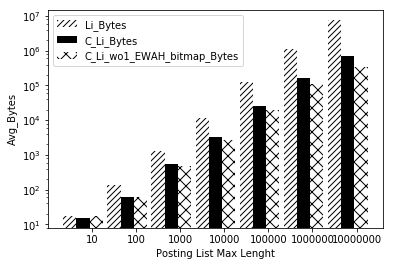

In [16]:
figure, ax = plt.subplots()
x = np.arange(7)

width = 0.30

ax.bar(x, average_Li_Bytes_indexData, width, color='w', hatch='////', label='Li_Bytes')
ax.bar(x + width, average_C_Li_Bytes_indexData, width , color='black', label='C_Li_Bytes')
ax.bar(x + width * 2, average_C_Li_wo1_EWAH_bitmap_Bytes_indexData, width , color='w',  hatch='xx', label='C_Li_wo1_EWAH_bitmap_Bytes')

plt.xticks(x + 0.5, map(lambda x: str(x), logBins))

ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Avg_Bytes')
ax.set_yscale('log')
ax.legend(loc=2)

print "PLML\t\t Li_Bytes\t\tC_Li_Bytes \t\tC_Li_wo1_EWAH_bitmap_Bytes"
for i, (a, b, c) in enumerate(zip(average_Li_Bytes_indexData, average_C_Li_Bytes_indexData, average_C_Li_wo1_EWAH_bitmap_Bytes_indexData)):
    print "%i , %i , %i , %i" % (logBins[i], a, b, c)

PLML		 Li_Bytes		C_Li_Bytes 		C_Li_wo1_EWAH_bitmap_Bytes
10 , 14650900 , 12544964 , 14110444
100 , 123020460 , 57920056 , 54886978
1000 , 361244416 , 155437088 , 133574232
10000 , 998941432 , 285713260 , 236943236
100000 , 2334083708 , 479957120 , 373196968
1000000 , 4685821968 , 683962628 , 463211026
10000000 , 2846988736 , 264543000 , 124434168


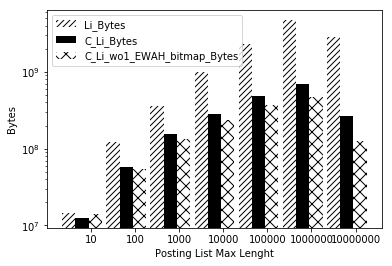

In [17]:
figure, ax = plt.subplots()
x = np.arange(7)

width = 0.30

ax.bar(x, Li_Bytes_indexData, width, color='w', hatch='////', label='Li_Bytes')
ax.bar(x + width, C_Li_Bytes_indexData, width , color='black', label='C_Li_Bytes')
ax.bar(x + width * 2, C_Li_wo1_EWAH_bitmap_Bytes_indexData, width , color='w',  hatch='xx', label='C_Li_wo1_EWAH_bitmap_Bytes')

plt.xticks(x + 0.5, map(lambda x: str(x), logBins))

ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Bytes')
ax.set_yscale('log')
ax.legend(loc=2)

print "PLML\t\t Li_Bytes\t\tC_Li_Bytes \t\tC_Li_wo1_EWAH_bitmap_Bytes"
for i, (a, b, c) in enumerate(zip(Li_Bytes_indexData, C_Li_Bytes_indexData, C_Li_wo1_EWAH_bitmap_Bytes_indexData)):
    print "%i , %i , %i , %i" % (logBins[i], a, b, c)

In [46]:
print "PLML\t\t # of Posting Lists per Bin"
for i, a in enumerate(bin_absolute_proportion_indexData):
    print "%i , %.2f" % (logBins[i], a)

PLML		 # of Posting Lists per Bin
10 , 820694.00
100 , 925068.00
1000 , 278805.00
10000 , 86016.00
100000 , 19157.00
1000000 , 4163.00
10000000 , 378.00
